# 2021-01-06 • ROC

Calculate & draw an ROC curve for connecton detection performance in the N-to-1 simulation.

## Setup

In [4]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [5]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Sat 09 Jan** 2021, at 23:24 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/e5acaa070cdab5ce683003777b5f58e143e1e894
) (Sat 09 Jan 2021, 23:16).

Uncommited changes to:
```
 M notebooks/2021-01-06__ROC.ipynb
```

## Sim

In [6]:
params = v.N_to_1_simulation.default_params
v.pprint(params)

N_to_1_SimParams
----------------
        time_grid = {'duration': 600, 'start': 0, 'timestep': 0.0001}
 num_spike_trains = 30
      p_connected = 0.5
       spike_rate = 20
           Δg_syn = 8E-10
            τ_syn = 0.007
    neuron_params = {'C': 1e-10, 'a': 30.0, 'b': -2e-09, 'c': -0.05, ...}
imaging_spike_SNR = 10


In [24]:
sim_data = v.N_to_1_simulation.simulate(params);

In [32]:
v.pprint(sim_data, values=False)

N_to_1_SimData
--------------
spike_trains       : NDArray[(num_spike_trains,), SpikeTimes]
is_connected       : NDArray[(num_spike_trains,), bool]
all_incoming_spikes: SpikeTimes
g_syn              : Signal
izh_output         : IzhikevichOutput
VI_signal          : Signal


In [27]:
zoom = params.time_grid.zoom(start=1 * second, duration=0.1 * second);

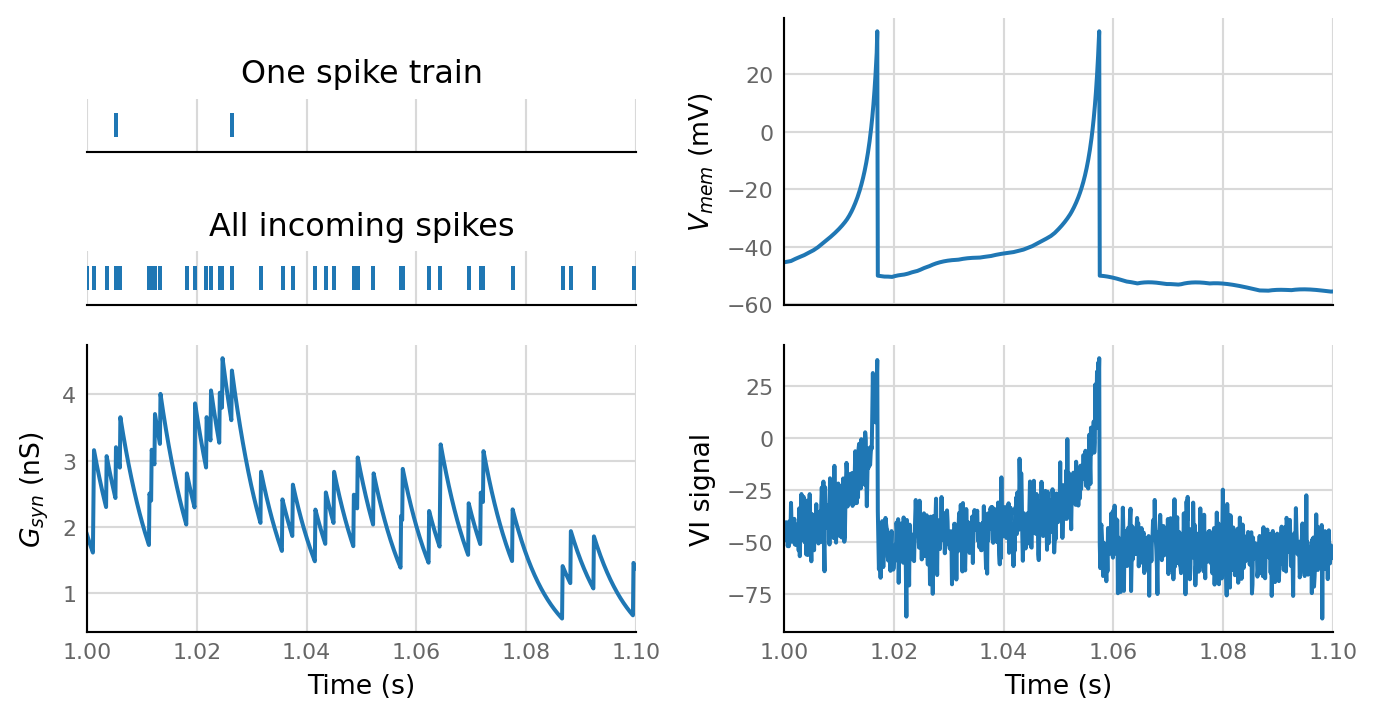

In [28]:
v.N_to_1_simulation.plot(sim_result, zoom)

## Permutation tests

In [12]:
from tqdm import tqdm as timed_loop

test_data = []
test_summaries = []

for spike_train in timed_loop(sim_result.all_spike_trains):
    data, summary = v.test_connection(spike_train, 
                                      sim_result.VI_signal,
                                      window_duration=100 * ms,
                                      num_shuffles=100)
    test_data.append(data)
    test_summaries.append(summary)

100%|██████████| 30/30 [00:10<00:00,  2.74it/s]


## Classify as connected

In [66]:
def apply_threshold(connection_test_summaries, p_value_threshold):
    is_classified_as_connected = np.array(
        [summary.p_value < p_value_threshold
         for summary in connection_test_summaries]
    )
    return is_classified_as_connected

is_classified_as_connected = apply_threshold(test_summaries, p_value_threshold = 0.1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False])

## Evaluate classification

In [65]:
def evaluate_classification(is_classified_as_connected, is_connected):
    is_TP = is_classified_as_connected & is_connected
    is_FP = is_classified_as_connected & ~is_connected
    is_TN = ~is_classified_as_connected & ~is_connected
    is_FN = ~is_classified_as_connected & is_connected
    num_TP = np.sum(is_TP)
    num_FP = np.sum(is_FP)
    num_TN = np.sum(is_TN)
    num_FN = np.sum(is_FN)
    TPR = num_TP / (num_TP + num_FN)
    FPR = num_FP / (num_FP + num_TN)
    return ClassificationEvaluation(
        is_TP, is_FP, is_TN, is_FN, num_TP, num_FP, num_TN, num_FN, TPR, FPR
    )


# boilerplate: (programming lang should generate this automatically)

from dataclasses import dataclass
from nptyping import NDArray
from typing import Any


NumSpikeTrains = Any
IndexArray = NDArray[(NumSpikeTrains,), bool]

@dataclass
class ClassificationEvaluation:
    is_TP: IndexArray
    is_FP: IndexArray
    is_TN: IndexArray
    is_FN: IndexArray
    num_TP: int
    num_FP: int
    num_TN: int
    num_FN: int
    TPR: float
    FPR: float


# test
classification_eval = evaluate_classification(is_classified_as_connected, sim_data.is_connected)
v.pprint(classification_eval)

ClassificationEvaluation
------------------------
 is_TP = array([ True,...False, False])
 is_FP = array([False,... True, False])
 is_TN = array([False,...False,  True])
 is_FN = array([False,...False, False])
num_TP = 15
num_FP = 1
num_TN = 14
num_FN = 0
   TPR = 1
   FPR = 0.06667


## ROC…

## Reproducibility

In [9]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Thu 07 Jan** 2021, at 13:35 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/1d6dcfe5863c45a4221e1d3268fb8c94828008e6
) (Thu 07 Jan 2021, 13:19).

Uncommited changes to:
```
 M notebooks/2021-01-06__ROC.ipynb
```

Platform:

Windows-10
CPython 3.8.5 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.3
numba                0.52.0
seaborn              0.11.1
scipy                1.6.0
scikit-learn         0.24.0
preload              2.2
py-cpuinfo           7.0.0
nptyping             1.4.0
tqdm                 4.55.1
